# MAIN
This is the master notebook for my AirBnB Recruiting Challenge work. Changes and additions are made by branching and merging.

Other possible branches:
* Explore
* Prepocessing
* Features
* Models
* Multiclass
* Imbalance
* Validation
* Ensembels
* Imputation
* Test
* PCA


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
#sns.set_context("talk")

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Get Data

In [2]:
# Load data into DataFrames
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')

piv_train = train_users.shape[0]
labels = train_users['country_destination'].values


all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True)

## Measure: NDCG

In [3]:
from rank_metrics import ndcg_at_k
from sklearn.metrics import make_scorer

def ndcg_wrapper(y_true,y_pred_proba):
    
    Y = np.fliplr(y_pred_proba.argsort())
        
    R = []
    NDCG = []
    for i in range(0,y_true.size):
        r = (Y[i,:]==y_true[i]).astype(int)
        R.append(r)
        #ndcg_at_k([0,0,1],5,method=1)
        NDCG.append(ndcg_at_k(r,5,method=1))
    
    #print(NDCG)
    #return NDCG,R
    return np.mean(NDCG)

ndcg_scorer = make_scorer(ndcg_wrapper, greater_is_better=True, needs_proba=True)

In [4]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#  Features 

## Preprocessing of Main Features

In [5]:
def preprocess_missing(df):
    ##AGE
    
    ## DISCRETIZE AGE
    A = pd.cut(df['age'],list(range(14,100,5)),right=True)
    A = pd.get_dummies(A)
    df= pd.concat([df,A],axis=1)
    
    #Remove all ages outside of range, set to -1 for separate categorisation //impute for logistic regression
    df.loc[df.age > 100, 'age'] = np.nan
    df.loc[df.age < 15, 'age'] = np.nan
    df['age'].fillna(-111,inplace=True)

    ## GENDER
    # Set missing values to own category
    df['gender'].replace('-unknown-',np.nan, inplace=True)
    #df['gender'].fillna('MISSING',inplace=True)

    ## FIRST AFFILIATE TRACKED
    # Set missing to untracked, hopefully the same
    df['first_affiliate_tracked'].fillna('untracked',inplace=True)
    
    ## Get rid of date_first_booking
    if 'date_first_booking' in df.columns:
        df.drop(['date_first_booking'],axis=1,inplace=True)
    
    return df

def preprocess_features(df):
    ## dates
    
    # date_account_created
    dac = np.vstack(df.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
    df['dac_year'] = dac[:,0]
    df['dac_month'] = dac[:,1]
    df['dac_day'] = dac[:,2]
    df.drop(['date_account_created'],axis=1,inplace=True)
    
    #time first active
    tfa = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
    df['tfa_year'] = tfa[:,0]
    df['tfa_month'] = tfa[:,1]
    df['tfa_day'] = tfa[:,2]
    df['tfa_hour'] = tfa[:,3]
    df.drop(['timestamp_first_active'],axis=1,inplace=True)
    
    
    ## One-Hot Encoding
    categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                            'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method'
                           ]
    
    df = pd.get_dummies(df,columns=categorical_features)
    
    return df

def preprocess_all(df):

    df_p = preprocess_missing(df)
    df_p = preprocess_features(df_p)
    
    return(df_p)

In [6]:
All = preprocess_all(all_users) 

## Session Features

In [7]:
session_df = pd.read_csv('input/sessions.csv')

#### Counts of Actions Taken

In [8]:
session_users = session_df

# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

# Combine for grouping
#session_users['action_action_type'] = session_users['action']+'__'+session_users['action_type']
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
#session_users['action_action_type_detail'] = session_users['action']+'__'+session_users['action_type']+'__'+session_users['action_detail']


# Group actions for users
#session_users1 = session_users.groupby(['user_id','action_action_type']).count()['secs_elapsed'].unstack().fillna(0)
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)
#session_users3 = session_users.groupby(['user_id','action_action_type_detail']).count()['secs_elapsed'].unstack().fillna(0)


In [9]:
#session_users2.head(2)

#### Elapsed Time by Device Type

In [10]:
deviceusage_df = session_df[['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']
deviceusage_df.fillna(0,inplace=True)
#deviceusage_df.head(2)

#### Combine Extracted Features

In [11]:
SessionFeatures = pd.merge(session_users2,deviceusage_df,right_index=True,left_index=True,how='inner')

#### Session Feature Selection

In [12]:
k = 150

#Need to use labelled to select
SessionX = pd.merge(train_users[['id','country_destination']],SessionFeatures,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']
SessionX.drop(['id','country_destination'],axis=1,inplace=True)

#test_users2 = 

In [13]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=150)
selector.fit(SessionX,Sessiony)
SessionFeatures = SessionFeatures[SessionFeatures.columns[selector.get_support()]]

c:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  5   7  10  12  15  16  63  65  80  82  83  84  85  89  90  92 114 124
 127 131 135 136 141 154 171 179 188 196 197 198 199 200 201 203 239 258
 259 319 324 332 334 335 339 343 348 349 360 362 378 383 386 390 393 411
 427] are constant.
  UserWarning)


## Age_Gender_Bkts - Create Features
Could also add in Country Locations here . . . if that makes a difference.

In [14]:
age_gender_df = pd.read_csv('input/age_gender_bkts.csv')

In [15]:
A = pd.pivot_table(age_gender_df,values='population_in_thousands',index=['age_bucket','gender'],columns='country_destination')
normalised_brackets = A.divide(A.sum(axis=1),axis=0)
normalised_totals = A.sum()/A.sum().sum()
#normalised_brackets

In [16]:
#AA = A.reset_index().groupby('gender').sum()  ## - Later separate missing by male and female . . . very sligth difference?
#AA.loc['female']/AA.loc['male']

In [17]:
def age_bucket_converter(age, gender):
    
    
    if (age>0)&(age<100):
        a = int((age//5)*5)
        Age = str(a)+'-'+str(a+4)
        if Age == '5-9': Age = 'Missing'
        
    elif age>99: Age = '100+'
    else: Age = 'Missing'
        
    if gender == 'MALE': Gender = 'male'
    elif gender == 'FEMALE': Gender = 'female'
    else: Gender = 'Missing'
    
    return (Age, Gender)

def bkts_feature_create(age_gender,normalised_brackets,normalised_totals):
     
    Age,Gender = age_bucket_converter(*age_gender)
    #print([Age,Gender])
    
    if ((Age=='Missing')|(Gender=='Missing')):
        return normalised_totals
    else:
        return normalised_brackets.loc[(Age,Gender)]

##### Create Features

In [18]:
BracketFeatures = all_users[['age','gender']].apply(lambda x: bkts_feature_create(tuple(x.values),normalised_brackets,normalised_totals),axis=1)
BracketFeatures.set_index(all_users['id'],inplace=True)

## SELECT AND COMBINE FEATURES ----------------------------------------------------------------------------

In [19]:
## Merge with Bracket Features
All = All.merge(BracketFeatures,how='inner',left_on='id',right_index=True) 

## Merge with Session Features
All = All.merge(SessionFeatures,how='inner',left_on='id',right_index=True)

print('num users total = ',All.shape[0])
print('num features = ',All.shape[1])

# Reattach Ids
#All['id'] = all_users['id']
#X = X.merge(SessionFeatures,how='inner',left_on='id',right_index=True) 

num users total =  135038
num features =  339


## SELECT TRAINING EXAMPLES - Which classes?

In [184]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#included_destinations = ['NDF','US']
included_destinations = ['NDF','US','FR','IT','other']

X  = All[All['country_destination'].apply(lambda x: x in included_destinations)]
y = le.fit_transform(X['country_destination'])

X = X.drop(['country_destination','id'],axis=1)

X_Test = All[All['country_destination'].isnull()].drop(['country_destination','id'],axis=1)
X_Test_ids = All[All['country_destination'].isnull()]['id']

print(list(zip(le.classes_,range(0,len(y)))))

[('FR', 0), ('IT', 1), ('NDF', 2), ('US', 3), ('other', 4)]


## SKEW HANDLING - SAMPLING TECHNIQUES

In [161]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=7,stratify=y)


In [26]:
XX  = All[All['country_destination'].apply(lambda x: x in included_destinations)]

In [30]:
XX.groupby('country_destination').count()['id'].sort_values(ascending=False)

country_destination
NDF      44791
US       19977
other     3630
FR        1425
IT         976
Name: id, dtype: int64

In [141]:
from unbalanced_dataset import UnderSampler, OverSampler, SMOTE

In [140]:
# Undersampling
US = UnderSampler()
X_us,y_us = US.fit_transform(X.values,y)

Determining classes statistics... 5 classes detected: {0: 1425, 1: 976, 2: 44791, 3: 19977, 4: 3630}
Under-sampling performed: Counter({0: 976, 1: 976, 2: 976, 3: 976, 4: 976})


In [23]:
# Oversampling
OS = OverSampler()
X_os,y_os = OS.fit_transform(X.values,y)

Determining classes statistics... 2 classes detected: {0: 44791, 1: 19977}
Over-sampling performed: Counter({0: 44791, 1: 39954})


In [156]:
# Undersampling + Oversampling
US = UnderSampler(ratio = 30)
X_us,y_us = US.fit_transform(X.values,y)
OS = OverSampler(10)
X_usos,y_usos = OS.fit_transform(X_us,y_us)

Determining classes statistics... 5 classes detected: {0: 1140, 1: 781, 2: 35833, 3: 15982, 4: 2904}
Under-sampling performed: Counter({2: 23430, 3: 15982, 4: 2904, 0: 1140, 1: 781})
Determining classes statistics... 5 classes detected: {0: 1140, 1: 781, 2: 23430, 3: 15982, 4: 2904}
Over-sampling performed: Counter({2: 23430, 3: 23430, 4: 23430, 0: 12540, 1: 8591})


In [162]:
# Undersampling + SMOTE
US = UnderSampler(ratio = 30)
X_us,y_us = US.fit_transform(X.values,y)

SMT = SMOTE(ratio=20,verbose=True,kind='regular')
X_sm,y_sm = SMT.fit_transform(X_us,y_us)



Determining classes statistics... 5 classes detected: {0: 1140, 1: 781, 2: 35833, 3: 15982, 4: 2904}
Under-sampling performed: Counter({2: 23430, 3: 15982, 4: 2904, 0: 1140, 1: 781})
Determining classes statistics... 5 classes detected: {0: 1140, 1: 781, 2: 23430, 3: 15982, 4: 2904}
Finding the 5 nearest neighbours...done!
Creating synthetic samples...Generated 15620 new samples ...
done!


In [144]:
X_sm.shape

(74808, 337)

In [145]:
X_us.shape

(55288, 337)

In [74]:
X = pd.DataFrame(data=X_us,columns=X.columns)
y = y_us

In [53]:
X = pd.DataFrame(data=X_os,columns=X.columns)
y = y_os

In [94]:
X.shape

(45071, 337)

In [95]:
y.shape

(45071,)

In [158]:
X_train,y_train = X_usos,y_usos

In [163]:
X_train,y_train = X_sm,y_sm

In [146]:
X,y = X_sm,y_sm

In [ ]:
## Custom CV Loop


In [170]:
RF = RandomForestClassifier(oob_score=True,n_estimators=100,n_jobs=-1,class_weight='balanced')
Xsave = X
ysave = y

cv = 5 #number of folds
cv_score = []

for i in range(0,cv):
    X, X_test, y, y_test = train_test_split(Xsave, ysave, test_size=0.2,random_state=i,stratify=ysave)
    
    US = UnderSampler(ratio = 30,verbose=False)
    SMT = SMOTE(ratio=20,kind='regular',verbose=False)
    X_us,y_us = US.fit_transform(X.values,y)
    X_sm,y_sm = SMT.fit_transform(X_us,y_us)
    RF.fit(X_sm,y_sm)
    cv_score.append(ndcg_scorer(RF,X_test,y_test))

    

In [168]:
print('cv scores = ',cv_score)
print('mean cv score = ',np.mean(cv_score))

cv scores =  [0.87697554925754617, 0.87579425176473558, 0.87951814081441093, 0.87881461264266303, 0.87741907738587643]
mean cv score =  0.877704326373


In [171]:
print('cv scores = ',cv_score)
print('mean cv score = ',np.mean(cv_score))

cv scores =  [0.87813629795312609, 0.87880735479738747, 0.87720367606278149, 0.87791236563351216, 0.87689356794031226]
mean cv score =  0.877790652477


In [ ]:
## Standalone
RF = RandomForestClassifier(oob_score=True,n_estimators=100,n_jobs=-1,class_weight='balanced')
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

clf = RF

ndcg_scorer(RF,X_test,y_test)

# MODELS -------------------------------------------------------------------------------------------

In [ ]:
#Imports
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing


### 0. Dummy Estimator

In [147]:
## Compare with basic. If you can't beat this, there's a probelm.

from sklearn.dummy import DummyClassifier
Dummy = DummyClassifier(strategy='prior').fit(X,y)
dummy_score = ndcg_scorer(Dummy,X,y)
dummy_score

0.72605413037798405

### 1. Logistic Regression
Logistic Regression without Grid Search on gets CrossVal of 0.657, which is a mild improvement over 0.583 for setting all NDF. Balancing classes brings it down negligably to 0.646
Grid search doesn't seemed to have helped - 0.658 with C of 11.94
After scaling age, this now appears third largest among the coefficients, though seemingly a decrease in accuracy to 0.63

Discretizing age has increased the score to 0.667, on 1% up. It's something.But none of the age variables features in important coefficients.
Reintoducing age as continuous (with NaNs imputed) together with discrete , brings things now up to 0.675. Huh

Interesting. The score on the training data is almost the same. So we might not be overfitting and just have too high bias.

And now the age brackets are appearing in the coeffs. How very strange. Seems that having entered your age validly correlates with actually booking. Now gender isn't showing up though. Could there just be the single latent variable of "filling out the form properly?"

Next run of GridSearch gives ~5 for C, stronger regularisation, and a score of 0.688, which is several points up from when I started.

----------------- 

Changing now to multiclass, helps with developing NDCG.


In [ ]:

## Customise Train and Test for Logistic Regression

def lr_preprocess(X):
    # Accepts already processed X and y

    ## DISCRETIZE AGE
    #X_log = X # Create X just for Logistic Regression
    #A = pd.cut(X_log['age'],list(range(14,100,5)),right=True)
    #A = pd.get_dummies(A)
    #X_log= pd.concat([X_log,A],axis=1)
    #X_train.drop(['age'],axis=1,inplace=True)


    ## IMPUTE VALUES AND SCALE
    X['age'].replace(-1,np.median(X['age']),inplace=True)
    scaler = preprocessing.MinMaxScaler()
    X['age'] = scaler.fit_transform(X['age'])

    return X

In [ ]:
All_log = lr_preprocess(All)
All_log.shape

In [ ]:
#%%timeit -r1
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(Cs=5,class_weight='balanced') #class_weight='balanced'
clf.fit(X_log,y_log)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.0045,class_weight='balanced')
print(np.mean(cross_val_score(clf,X_log,y_log,cv=5,scoring=ndcg_scorer)))

In [ ]:
#%%timeit -r1
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C = 0.0005,class_weight='balanced')

#Need to stratify.
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('NDCG = ',ndcg_scorer(clf,X_test,y_test))
print('Accuracy = ',metrics.accuracy_score(y_test,y_pred))


In [ ]:
%%timeit
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C ,class_weight='balanced') #class_weight='balanced'
clf.fit(X_log,y_log)


In [ ]:
print('NDCG = ',ndcg_scorer(clf,X_test,y_test))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, random_state=0)
ndcg_scorer(clf,X_test,y_test)


In [ ]:
## Test for overfitting:
y_pred = clf.predict(X_train)
print('NDCG = ',ndcg_scorer(clf,X_train,y_train))
print('Accuracy = ',metrics.accuracy_score(y_train,y_pred))
print('Recall = ',metrics.recall_score(y_train,y_pred))
print('Precision = ',metrics.precision_score(y_train,y_pred))

### Grid Search

In [ ]:
Crange = np.logspace(-1,2,30)

grid = GridSearchCV(LogisticRegression(), param_grid={'C': Crange},scoring='accuracy',cv=3,n_jobs=4)
grid.fit(X_train,y_train)
print ("best parameter choice:", grid.best_params_)
print ("best score:", grid.best_score_)


### Feature Importances - Logistic Regression

In [ ]:
FeatureImportances = pd.DataFrame(data = { 'coefs': clf.coef_.squeeze(), 'abs coefs' : np.abs(clf.coef_.squeeze())},index=X_log.columns)
FeatureImportances.sort_values(by='abs coefs',ascending=False,inplace=True)

k = 50
plt.figure(figsize=(10,10))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances['coefs'].head(k))
#plt.xticks(rotation = 90)

The picture I get from this that people are less likely to book from mobile devices. And more likely to book if they correctly filled out their from. I doubt logicst regression has handled the age feature well. Hence why discretizing might be a good idea.

## 2. Random Forest -------------------------------------

### Notes

Very first attempt got 0.8449, which is negligibly higher than the dummy estimator at 0.84055

I'm confused, why does my simple train test split give 0.82 while the GridSearch gets a mere 0.75

Adding in session features seems to help a lot. First train-test split gives 0.8835. Hmm, note that that one isn't weighted.
0.879 with threefold cross validation. Looks good, gives a 3.1% improvement over dummy, which is something.

Looking at confusion matrix, everything is either US or NDF, never predict anything as Italy, France, or Other.

### Custom Preprocessing

In [ ]:
# Doesn't require any yet.

### Model

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [133]:
## Train on all data (for LB submission)
RF = RandomForestClassifier(oob_score=True,n_estimators=200,n_jobs=-1,class_weight='balanced')
RF.fit(X,y)
clf = RF

In [159]:
## Standalone
RF = RandomForestClassifier(oob_score=True,n_estimators=100,n_jobs=-1,class_weight='balanced')
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

clf = RF

ndcg_scorer(RF,X_test,y_test)

0.87660816081276727

In [186]:
## Standalone
RF = RandomForestClassifier(oob_score=True,n_estimators=100,n_jobs=-1,class_weight='balanced')
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

clf = RF

ndcg_scorer(RF,X_test,y_test)

0.88186985026931464

In [150]:
from sklearn.cross_validation import cross_val_score
RF = RandomForestClassifier(oob_score=True,n_estimators=200,n_jobs=-1,class_weight='balanced')
CV_score = cross_val_score(RF,X,y,scoring=ndcg_scorer, cv=5, verbose=2)
print('CV scores = ',CV_score)
print('Mean CV score = ', np.mean(CV_score))

[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  17.9s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.2s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.3s
CV scores =  [ 0.92  0.95  0.95  0.96  0.95]
Mean CV score =  0.947783404785


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [ ]:
## GridSearch
RF = RandomForestClassifier(oob_score=True)
gridRF = GridSearchCV(RF,param_grid={'n_estimators':[100]}, #
                      scoring=ndcg_scorer,cv=4)
gridRF.fit(X,y)

print(gridRF.best_params_)
print(gridRF.best_score_)

In [ ]:
## GridSearch
RF = RandomForestClassifier(class_weight='balanced',oob_score=True)
gridRF = GridSearchCV(RF,param_grid={'n_estimators':[200],
                                   'max_features':[30]}, #
                      scoring=ndcg_scorer,cv=4)
gridRF.fit(X,y)

print(gridRF.best_params_)
print(gridRF.best_score_)

In [ ]:
RF_best = gridRF.best_estimator_
RF_best

In [191]:
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

OvO = OneVsRestClassifier(RandomForestClassifier(n_estimators=100,n_jobs=-1,class_weight='balanced'))
OvO.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [200]:
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

OvO = OneVsOneClassifier(RandomForestClassifier(n_estimators=100,n_jobs=-1,class_weight='balanced'))
OvO.fit(X_train.values, y_train)

OneVsOneClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [202]:
y_pred = OvO.predict(X_test)

In [204]:
metrics.accuracy_score(RF.predict(X_test),y_test)

0.71878531073446328

In [203]:
metrics.accuracy_score(y_pred,y_test)

0.72704802259887003

In [205]:
OvO.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [189]:
X_train

age  (14, 19]  (19, 24]  (24, 29]  (29, 34]  (34, 39]  (39, 44]  \
201422   37         0         0         0         0         1         0   
178738   30         0         0         0         1         0         0   
178839   25         0         0         1         0         0         0   
180796   51         0         0         0         0         0         0   
199306   40         0         0         0         0         0         1   
197819   39         0         0         0         0         1         0   
207637 -111         0         0         0         0         0         0   
206964 -111         0         0         0         0         0         0   
200976   49         0         0         0         0         0         0   
191612   21         0         1         0         0         0         0   
190517   32         0         0         0         1         0         0   
137290   29         0         0         1         0         0         0   
159926 -111         0         0         0         0         0         0   
138463 -111         0         0         0         0         0         0   
141903   66         0         0         0         0         0         0   
208614   26         0         0         1         0         0         0   
198843 -111         0         0         0         0         0         0   
185273   52         0         0         0         0         0         0   
157120   25         0         0         1         0         0         0   
164893 -111         0         0         0         0         0         0   
185104   28         0         0         1         0         0         0   
196511   34         0         0         0         1         0         0   
177548 -111         0         0         0         0         0         0   
156715   62         0         0         0         0         0         0   
161606 -111         0         0         0         0         0         0   
184513   30         0         0         0         1         0         0   
155737 -111         0         0         0         0         0         0   
185182   48         0         0         0         0         0         0   
211947 -111         0         0         0         0         0         0   
171299 -111         0         0         0         0         0         0   
...     ...       ...       ...       ...       ...       ...       ...   
149773   29         0         0         1         0         0         0   
172212   34         0         0         0         1         0         0   
209275   41         0         0         0         0         0         1   
198909   32         0         0         0         1         0         0   
209941 -111         0         0         0         0         0         0   
176641   56         0         0         0         0         0         0   
208149   27         0         0         1         0         0         0   
201274   29         0         0         1         0         0         0   
140123 -111         0         0         0         0         0         0   
157684 -111         0         0         0         0         0         0   
165625 -111         0         0         0         0         0         0   
169094 -111         0         0         0         0         0         0   
195361 -111         0         0         0         0         0         0   
142977   28         0         0         1         0         0         0   
210491   49         0         0         0         0         0         0   
207319 -111         0         0         0         0         0         0   
205238   26         0         0         1         0         0         0   
201888 -111         0         0         0         0         0         0   
137899 -111         0         0         0         0         0         0   
207212   34         0         0         0         1         0         0   
209715 -111         0         0         0         0         0         0   
182189   26         0         0  

In [211]:
A = OvO.decision_function(X_test)
A

array([[ 0.61, -0.27,  4.24,  3.24,  2.18],
       [ 0.6 , -0.34,  4.23,  3.26,  2.26],
       [ 0.59, -0.32,  4.25,  3.25,  2.23],
       ..., 
       [ 0.64, -0.29,  4.16,  3.29,  2.2 ],
       [ 0.65, -0.3 ,  3.09,  4.35,  2.21],
       [ 0.65, -0.32,  4.23,  3.25,  2.19]])

In [214]:
A.mean(axis=0)

array([ 0.45, -0.12,  3.89,  3.55,  2.23])

In [233]:
AA = pd.DataFrame(data=np.fliplr(le.inverse_transform(OvO.decision_function(X_test).argsort(axis=1))))

In [231]:
AAA.iloc[0].values.argsort()

array([1, 0, 4, 3, 2], dtype=int64)

In [ ]:
    Y = np.fliplr(y_pred_proba.argsort())


In [232]:
np.fliplr(AAA.iloc[0].values.argsort())

ValueError: Input must be >= 2-d.

In [224]:
AAA = pd.DataFrame(data=(OvO.decision_function(X_test)))
AAA

0         1         2         3         4
0      0.611406 -0.271883  4.244032  3.236074  2.180371
1      0.600796 -0.344828  4.230769  3.255968  2.257294
2      0.590186 -0.315650  4.245358  3.246684  2.233422
3      0.620690 -0.330239  4.258621  3.216180  2.234748
4      0.643236 -0.320955  4.236074  3.261273  2.180371
5     -0.429708  0.702918  4.214854  3.266578  2.245358
6      0.633952 -0.283820  4.240053  3.225464  2.184350
7      0.616711 -0.342175  4.218833  3.257294  2.249337
8      0.580902 -0.294430  4.188329  3.278515  2.246684
9      0.595491 -0.281167  3.171088  4.315650  2.198939
10    -0.440318  0.720159  4.224138  3.238727  2.257294
11     1.656499 -0.336870  4.263926  3.225464  1.190981
12     0.587533 -0.303714  4.236074  3.258621  2.221485
13     0.582228 -0.330239  4.226790  3.287798  2.233422
14     0.637931 -0.314324  3.120690  4.320955  2.234748
15     0.635279 -0.311671  4.189655  3.271883  2.214854
16     0.586207 -0.309019  4.238727  3.226790  2.257294
17     0.644562 -0.232095  1.977454  4.319629  3.290451
18    -0.412467  1.795756  4.244032  3.208223  1.164456
19     0.635279 -0.306366  4.173740  3.266578  2.230769
20     0.600796 -0.316976  4.262599  3.212202  2.241379
21     0.624668 -0.298408  4.251989  3.209549  2.212202
22     0.612732 -0.327586  4.220159  3.286472  2.208223
23     0.580902 -0.324934  3.149867  4.322281  2.271883
24     0.575597 -0.297082  4.257294  3.225464  2.238727
25     0.624668 -0.295756  3.155172  4.306366  2.209549
26     0.594164 -0.281167  3.155172  4.319629  2.212202
27     0.635279 -0.312997  4.226790  3.262599  2.188329
28     0.590186 -0.319629  3.163130  4.322281  2.244032
29     0.631300 -0.347480  4.257294  3.225464  2.233422
...         ...       ...       ...       ...       ...
14130  0.608753 -0.294430  4.228117  3.251989  2.205570
14131  0.580902 -0.289125  4.213528  3.240053  2.254642
14132  0.592838 -0.299735  4.253316  3.226790  2.226790
14133  0.659151 -0.356764  3.165782  4.302387  2.229443
14134  0.637931 -0.364721  4.201592  3.294430  2.230769
14135  0.603448 -0.278515  3.066313  4.343501  2.265252
14136 -0.425729  0.706897  4.248011  3.244032  2.226790
14137  0.645889 -0.315650  3.135279  4.324934  2.209549
14138  0.614058 -0.306366  4.262599  3.225464  2.204244
14139  0.586207 -0.326260  4.202918  3.289125  2.248011
14140  0.580902 -0.298408  3.163130  4.311671  2.242706
14141  0.586207 -0.327586  4.242706  3.248011  2.250663
14142  1.671088 -0.274536  3.087533  4.322281  1.193634
14143 -0.395225  0.744032  4.214854  3.258621  2.177719
14144  0.622016 -0.291777  2.003979  4.354111  3.311671
14145  0.610080 -0.293103  4.192308  3.278515  2.212202
14146  0.651194 -0.240053  3.041114  4.320955  2.226790
14147  0.623342 -0.293103  4.196286  3.283820  2.189655
14148 -0.493369  0.749337  4.257294  3.192308  2.294430
14149  0.612732 -0.293103  4.213528  3.250663  2.216180
14150  0.575597 -0.332891  4.237401  3.251989  2.267905
14151  0.590186 -0.299735  4.190981  3.290451  2.228117
14152  0.632626 -0.275862  3.104775  4.320955  2.217507
14153 -0.458886  0.725464  4.241379  3.244032  2.248011
14154  0.660477 -0.302387  3.034483  4.350133  2.257294
14155 -0.421751  0.713528  4.254642  3.249337  2.204244
14156 -0.427056  0.750663  4.253316  3.194960  2.228117
14157  0.639257 -0.294430  4.163130  3.294430  2.197613
14158  0.647215 -0.302387  3.092838  4.347480  2.214854
14159  0.647215 -0.324934  4.234748  3.251989  2.190981

[14160 rows x 5 columns]

In [219]:
OvO.decision_function(X_test).argsort().mean(axis=0)

array([ 0.82,  0.29,  3.85,  2.76,  2.28])

In [217]:
AA

0      1      2      3    4
0      IT     FR  other     US  NDF
1      IT     FR  other     US  NDF
2      IT     FR  other     US  NDF
3      IT     FR  other     US  NDF
4      IT     FR  other     US  NDF
5      FR     IT  other     US  NDF
6      IT     FR  other     US  NDF
7      IT     FR  other     US  NDF
8      IT     FR  other     US  NDF
9      IT     FR  other    NDF   US
10     FR     IT  other     US  NDF
11     IT  other     FR     US  NDF
12     IT     FR  other     US  NDF
13     IT     FR  other     US  NDF
14     IT     FR  other    NDF   US
15     IT     FR  other     US  NDF
16     IT     FR  other     US  NDF
17     IT     FR    NDF  other   US
18     FR  other     IT     US  NDF
19     IT     FR  other     US  NDF
20     IT     FR  other     US  NDF
21     IT     FR  other     US  NDF
22     IT     FR  other     US  NDF
23     IT     FR  other    NDF   US
24     IT     FR  other     US  NDF
25     IT     FR  other    NDF   US
26     IT     FR  other    NDF   US
27     IT     FR  other     US  NDF
28     IT     FR  other    NDF   US
29     IT     FR  other     US  NDF
...    ..    ...    ...    ...  ...
14130  IT     FR  other     US  NDF
14131  IT     FR  other     US  NDF
14132  IT     FR  other     US  NDF
14133  IT     FR  other    NDF   US
14134  IT     FR  other     US  NDF
14135  IT     FR  other    NDF   US
14136  FR     IT  other     US  NDF
14137  IT     FR  other    NDF   US
14138  IT     FR  other     US  NDF
14139  IT     FR  other     US  NDF
14140  IT     FR  other    NDF   US
14141  IT     FR  other     US  NDF
14142  IT  other     FR    NDF   US
14143  FR     IT  other     US  NDF
14144  IT     FR    NDF  other   US
14145  IT     FR  other     US  NDF
14146  IT     FR  other    NDF   US
14147  IT     FR  other     US  NDF
14148  FR     IT  other     US  NDF
14149  IT     FR  other     US  NDF
14150  IT     FR  other     US  NDF
14151  IT     FR  other     US  NDF
14152  IT     FR  other    NDF   US
14153  FR     IT  other     US  NDF
14154  IT     FR  other    NDF   US
14155  FR     IT  other     US  NDF
14156  FR     IT  other     US  NDF
14157  IT     FR  other     US  NDF
14158  IT     FR  other    NDF   US
14159  IT     FR  other     US  NDF

[14160 rows x 5 columns]

In [ ]:
gridRF.grid_scores_

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [209]:
classes

array(['FR', 'IT', 'NDF', 'US', 'other'], dtype=object)

In [67]:
CV_score

array([ 0.88284834,  0.88194498,  0.87735316,  0.87911648,  0.87900448])

In [60]:
CV_score

array([ 0.83926392,  0.81268852,  0.8225963 ,  0.83918911,  0.80749463])

In [61]:
np.mean(CV_score)

0.82424649673540418

In [68]:
np.mean(CV_score)

0.88005348819491014

#### Scores and Confusion Matrix

In [127]:
#dummy_score = ndcg_scorer(Dummy,X_test,y_test)
ndcg_score = ndcg_scorer(RF,X_test,y_test)
print('ndcg = ', ndcg_score)
print('dummy = ', dummy_score)
print('improvement over dummy: %3.3f%%' % ((ndcg_score - dummy_score)*100))

ndcg =  0.926243757326
dummy =  0.808319456703
improvement over dummy: 11.792%


In [175]:
clf = RF
y_pred = clf.predict(X_test) 
print(metrics.classification_report(y_test,y_pred,target_names=le.classes_))
print('ndcg = ', ndcg_score)

             precision    recall  f1-score   support

         FR       0.00      0.00      0.00       182
         IT       0.00      0.00      0.00       125
        NDF       0.80      0.83      0.81      5734
         US       0.54      0.66      0.60      2557
      other       0.25      0.00      0.00       465

avg / total       0.67      0.71      0.68      9063

ndcg =  0.926243757326


confusion matrix
[[   0    0   77  105    0]
 [   0    0   47   78    0]
 [   0    0 4749  983    2]
 [   2    2  864 1688    1]
 [   0    0  202  262    1]]


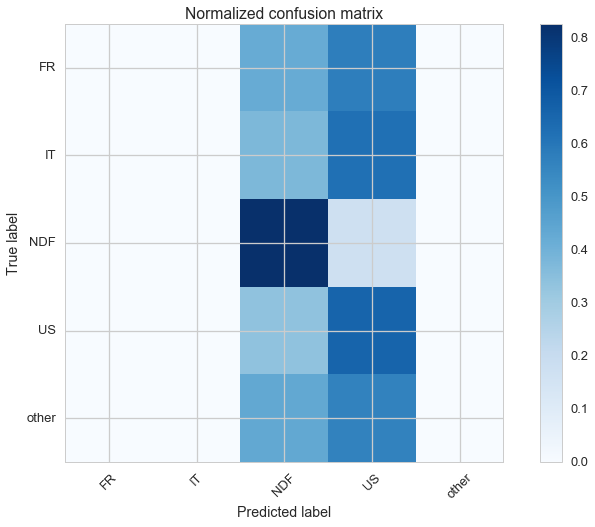

In [174]:
sns.set_context("talk")
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion matrix')
print(cm)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

### Feature Importance

In [ ]:
clf = RF_best

In [ ]:
FeatureImportances = pd.Series(index=X.columns,data=clf.feature_importances_).sort_values(ascending=False)

In [ ]:
k = 100
plt.figure(figsize=(10,20))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))


In [ ]:
k = 100
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
#plt.xticks(rotation = 90)

### Validation and Learning Curve

In [ ]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(clf, X, y,scoring=ndcg_scorer,train_sizes=[0.1,0.5,0.8,1])

In [ ]:
from plot_learning_curve import plot_learning_curve



In [ ]:
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
sns.set_context("talk")

plt.figure()
#plt.title(title)
#if ylim is not None: plt.ylim((0.7,1.01)
#plt.xlabel = 'H'
plt.xlabel("Training examples")
plt.ylabel("NDCG Score")

#train_sizes, train_scores, test_scores = learning_curve(    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.grid()


plt.grid()

In [ ]:
train_sizes

In [ ]:
from sklearn.learning_curve import validation_curve

train_scores, valid_scores = validation_curve(RandomForestClassifier(oob_score=True,n_jobs=-1,class_weight='balanced')
                                              , X, y, "n_estimators", [50,100,200,500],cv=2)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

param_range = [50,100,200,500]

plt.title("Validation Curve with RF")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean,'ro', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean,'go', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.learning_curve import validation_curve

train_scores, valid_scores = validation_curve(RandomForestClassifier(n_jobs=-1,class_weight='balanced')
                                              , X, y, "max_features", [10,20,50],cv=2)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

param_range = [10,20,50]

plt.title("Validation Curve with RF")
plt.xlabel("max_features")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean,'ro', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean,'go', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


## 2a. One-Vs-One RF

In [177]:
RF

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [185]:
from sklearn.multiclass import OneVsOneClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

OvO = OneVsOneClassifier(RF)
OvO.fit(X_train, y_train)

IndexError: indices are out-of-bounds

In [182]:
X_train.shape

(56639, 337)

In [183]:
y_train.shape

(56639,)

## 3. ExtraTrees

## 4. XGBoost

# TEST-SET PREDICTIONS

In [104]:
def create_sub(preds,id_test):
##Format predictions for Kaggle online submission
    
    n = 5

    ids = [] # list of id's
    cts = [] # list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx]*n
        cts += list(preds[i][0:n])
    
    submission = pd.DataFrame(np.column_stack((ids,cts)), columns=['id','country'])
    return submission

    
#submission.to_csv('output/sub_lr_2class_usndf_plus3_main_bkts.csv',index=False)

### Logistic Regression - US and NDF - Main + Age_Bracket Features

In [ ]:
X_log.head()
X_log_test.head()

In [ ]:
print(X_log.shape)
print(X_log_test.shape)

In [44]:
y_pred_test = clf.predict_proba(X_Test)
Y = np.fliplr(y_pred_test.argsort()) #Numbers of predicted classes in order of likelihood.
y_preds = le.inverse_transform(Y) #Converted to string labels.

In [45]:
y_preds

array([['NDF', 'US'],
       ['NDF', 'US'],
       ['NDF', 'US'],
       ..., 
       ['NDF', 'US'],
       ['NDF', 'US'],
       ['US', 'NDF']], dtype=object)

In [47]:
## Shoulde turn all of this into a function

n = 5

id_test = X_Test_ids.values

ids = [] # list of id's
cts = [] # list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx]*n
    cts += list(y_preds[i]) + ['other','FR','IT']


In [48]:
submission = pd.DataFrame(np.column_stack((ids,cts)), columns=['id','country'])
submission.to_csv('output/sub_lr_2class_usndf_plus3_main_bkts_UNDERSAMPLING.csv',index=False)

### Random Forest - 5 Top Countries - Including Feature Selected Session + Age_Gender_Bckts

In [134]:
clf = RF
print(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [40]:
X_Test.shape

(61635, 337)

In [135]:
#clf.fit(X,y)
test_users_proba = clf.predict_proba(X_Test)
test_users_preds = le.inverse_transform(np.fliplr(test_users_proba.argsort()))

In [102]:
test_users_preds[1][0:5]

array(['NDF', 'US', 'other', 'FR', 'IT'], dtype=object)

In [136]:
submission = create_sub(test_users_preds,X_Test_ids.values)

In [137]:
submission.to_csv('output/sub_rf_5class_top_main_bkts_OSUS30-10.csv',index=False)

# BELOW HERE IS MESSY - OLD CODE

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)



forest.fit(X_log, y_int)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_log.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_log.shape[1]), indices)
plt.xlim([-1, X_log.shape[1]])
plt.show()

In [ ]:
## Let's get a classifier going
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X_log, y_log, random_state=0)

clf = RandomForestClassifier(n_estimators=25)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)


In [ ]:
FeatureImportances = pd.Series(index=X_log.columns,data=clf.feature_importances_).sort_values(ascending=False)

In [ ]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)

In [ ]:
k = 50
plt.figure(figsize=(10,15))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))
#plt.xticks(rotation = 90)